In [1]:
from lemaitre import georges
georges.setup_logger(level='INFO')
from lemaitre import bandpasses

filterlib = bandpasses.get_filterlib()

2025-06-03 16:12:17 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.44fa250da9a1f29e6032255a6f85739144004c18874eca1d1317696bbce56e78.pkl


Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Wednesday 4th from 11h to 12h


In [2]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-06-03 16:12:18 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /home/okc/.cache/bbf/lemaitre_flib.default.44fa250da9a1f29e6032255a6f85739144004c18874eca1d1317696bbce56e78.pkl
2025-06-03 16:12:18 INFO arviz.preview - arviz_base not installed
2025-06-03 16:12:18 INFO arviz.preview - arviz_stats not installed
2025-06-03 16:12:18 INFO arviz.preview - arviz_plots not installed
INFO:2025-06-03 16:12:18,685:jax._src.xla_bridge:924: Unable to initialize backend 'cuda': 
2025-06-03 16:12:18 INFO jax._src.xla_bridge - Unable to initialize backend 'cuda': 
INFO:2025-06-03 16:12:18,686:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-06-03 16:12:18 INFO jax._src.xla_bridge - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-03 16:12:18,688:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open 

In [3]:
import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

## 2M++ halos loading

When drawing from the 2M++ grid, enforce z_max=0.11677 otherwise it's not isotrope 

In [4]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(name="2m++", H0=68.1, Om0=0.306)

In [5]:
from scipy.interpolate import interp1d

dc_to_z = interp1d(
    cosmo.comoving_distance(np.linspace(1e-4, 0.5, 10000)),
    np.linspace(1e-4, 0.5, 10000),
)

##### First loading

In [6]:
import h5py

In [124]:
with h5py.File("./data/reduced_hbt/mcmc_0.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(list(file["Subhalos"]))
    cosmo_params = {
        params: np.array(file["Cosmology"][params])[0]
        for params in list(file["Cosmology"])
    }
    positions = np.array(file["Subhalos"]["ComovingAveragePosition"])
    positions_mostbound = np.array(file["Subhalos"]["ComovingMostBoundPosition"])
    masses = np.array(file["Subhalos"]["BoundM200Crit"])
    radius = np.array(file["Subhalos"]["BoundR200CritComoving"])
    velocities = np.array(file["Subhalos"]["PhysicalAverageVelocity"])
    ids = np.array(file["Subhalos"]["HostHaloId"])
    rmax = np.array(file["Subhalos"]["RmaxComoving"])
    vmax = np.array(file["Subhalos"]["VmaxPhysical"])

Keys: <KeysViewHDF5 ['Cosmology', 'Subhalos']>
['BoundM200Crit', 'BoundR200CritComoving', 'ComovingAveragePosition', 'ComovingMostBoundPosition', 'HostHaloId', 'Nbound', 'PhysicalAverageVelocity', 'PhysicalMostBoundVelocity', 'RmaxComoving', 'TrackId', 'VmaxPhysical']


In [14]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc

for k in tqdm(range(50)):

    with h5py.File(f"./data/reduced_hbt/mcmc_{k}.hdf5", "r") as file:
        properties = {key:np.array(file["Subhalos"][key]) for key in ["HostHaloId", "BoundM200Crit", "BoundR200CritComoving"]}
        pos_vel = {key+ax: np.array(file["Subhalos"][key])[:,i] for key in ["ComovingAveragePosition", "PhysicalAverageVelocity"] for i, ax in enumerate(["_x", "_y", "_z"])}
        halos = pandas.DataFrame(properties | pos_vel).rename(columns=lambda x : 'pos'+x[-2:] if "Position" in x else 'v' + x[-2:] if "Velocity" in x else x)
        halos.pos_x -= 500
        halos.pos_y -= 500
        halos.pos_z -= 500

        halos["d_c"] = np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

        halos["vpec"] = (
            halos.pos_x * halos.v_x + halos.pos_y * halos.v_y + halos.pos_z * halos.v_z
        ) / halos.d_c
        halos["z_cosmo"] = dc_to_z(halos.d_c)
        halos["z"] = (1 + halos.z_cosmo) * (1 + halos.vpec / c * 1e3) - 1

        coords = SkyCoord(
            x=halos.pos_x,
            y=halos.pos_y,
            z=halos.pos_z,
            representation_type="cartesian",
            unit=Mpc,
        )
        halos["ra"] = coords.icrs.spherical.lon.value
        halos["dec"] = coords.icrs.spherical.lat.value
        halos.to_csv(f"data/reduced_hbt/halos_highres_{k}.csv")


  0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
with h5py.File("./data/delta_dm_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    delta = np.array(file["delta_dm"])

with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    print("Keys: %s" % file.keys())
    print(file["Header"])
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])

Keys: <KeysViewHDF5 ['Header', 'delta_dm']>
<HDF5 group "/Header" (0 members)>
Keys: <KeysViewHDF5 ['Header', 'velocity_field_0', 'velocity_field_1', 'velocity_field_2', 'velocity_field_radial']>
<HDF5 group "/Header" (0 members)>


In [134]:
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [69]:
halos = pandas.DataFrame(
    {
        "pos_x": positions.T[0] - 500,
        "pos_y": positions.T[1] - 500,
        "pos_z": positions.T[2] - 500,
        "vx": velocities.T[0],
        "vy": velocities.T[1],
        "vz": velocities.T[2],
        "M200c": masses,
        "radius": radius,
        "halo_id": ids,
        "Rmax": rmax,
        "vmax": vmax
    }
)


halos["d_c"] = np.sqrt(halos.pos_x**2 + halos.pos_y**2 + halos.pos_z**2)

halos["vpec"] = (
    halos.pos_x * halos.vx + halos.pos_y * halos.vy + halos.pos_z * halos.vz
) / halos.d_c

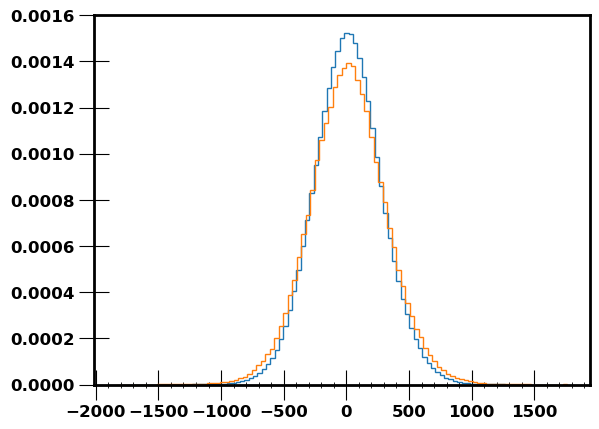

In [70]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step")

In [71]:
halos["z_cosmo"] = dc_to_z(halos.d_c)

In [72]:
halos["z"] = (1 + halos.z_cosmo) * (1 + halos.vpec / c * 1e3) - 1

In [73]:
from astropy.coordinates import SkyCoord
from astropy.units import Mpc

coords = SkyCoord(
    x=halos.pos_x,
    y=halos.pos_y,
    z=halos.pos_z,
    representation_type="cartesian",
    unit=Mpc,
)

In [94]:
halos["ra"] = coords.icrs.spherical.lon.value
# halos.ra -= (halos.ra > 180) * 360
halos["dec"] = coords.icrs.spherical.lat.value

In [95]:
halos.to_csv("data/2M++_subhalo_1.csv")

##### Some plots

In [7]:
halos = pandas.read_csv("data/2M++_subhalo_0.csv")
halos_ = pandas.read_csv("data/2M++_subhalo_1.csv")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)
ax.scatter(halos_.pos_x, halos_.pos_y, halos_.pos_z, s=2, marker=".", alpha=0.1)

In [ ]:
one_axis = np.linspace(0, 1000, 256, endpoint=False)
y, x, z = np.meshgrid(one_axis, one_axis, one_axis)
centroids = np.c_[x.ravel(),y.ravel(),z.ravel()] + 1000/512

In [ ]:
from scipy.spatial import cKDTree
tree = cKDTree(centroids, boxsize=1000)

In [ ]:
dist, id = tree.query(np.c_[halos.pos_x, halos.pos_y, halos.pos_z] + 500)
dist_, id_ = tree.query(np.c_[halos_.pos_x, halos_.pos_y, halos_.pos_z] + 500)

In [ ]:
positions = (centroids - 500)

In [ ]:
with h5py.File("./data/velocity_cic_0.hdf5", "r") as file:
    vpec = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)
with h5py.File("./data/velocity_cic_1.hdf5", "r") as file:
    vpec_ = np.array(file["velocity_field_radial"])
    v_x = np.array(file["velocity_field_0"])
    v_y = np.array(file["velocity_field_1"])
    v_z = np.array(file["velocity_field_2"])
v_ = np.concatenate(
    [
        v_x.reshape(256, 256, 256, 1),
        v_y.reshape(256, 256, 256, 1),
        v_z.reshape(256, 256, 256, 1),
    ],
    axis=3,
)

In [ ]:
my_vpec = np.sum(positions[id]*v.reshape(-1, 3)[id], axis=1)/np.sqrt(np.sum(positions[id]**2, axis=1))
my_vpec_ = np.sum(positions[id_]*v_.reshape(-1, 3)[id_], axis=1)/np.sqrt(np.sum(positions[id_]**2, axis=1))

In [ ]:
calc_vpec=np.sum(np.multiply(v.reshape(-1, 3)[id], positions[id]), axis=1)/np.linalg.norm(positions[id], ord=2, axis=1)
calc_vpec_=np.sum(np.multiply(v_.reshape(-1, 3)[id_], positions[id_]), axis=1)/np.linalg.norm(positions[id_], ord=2, axis=1)

In [ ]:
halos['calc_vpec'] = calc_vpec
halos_['calc_vpec'] = calc_vpec_

In [ ]:
halos.columns

In [ ]:
fig = corner_(halos, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], return_fig=True)
corner_(halos_, var_names=["pos_x", "pos_y", "pos_z", "vx", "vy", "vz", "vpec", "calc_vpec"], fig=fig, color='r')
plt.tight_layout()

In [ ]:
plt.hist(vpec.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


In [ ]:
plt.hist(vpec_.ravel(), bins=100, density=True, histtype="step", label=r"$VP_{grid}$")
_ = plt.hist(calc_vpec_, bins=100, density=True, histtype="step", label=r"$VP_{calc}$")
_ = plt.hist(halos_.vpec, bins=100, density=True, histtype="step", label=r"$VP_{halos}$")
plt.legend()


In [ ]:
_ = plt.hist(calc_vpec - halos.vpec, bins=100, density=True, histtype="step", label=r"$VP_{calc} - VP_{halos}$")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))
ax.scatter(*positions[id].T, s=2, marker=".", alpha=0.1)
ax.scatter(halos.pos_x, halos.pos_y, halos.pos_z, s=2, marker=".", alpha=0.1)

In [ ]:
_=plt.hist(vpec.ravel()[id_] - halos_.vpec, bins=100)
mean, std = (vpec.ravel()[id_] - halos_.vpec).mean(), (vpec.ravel()[id_] - halos_.vpec).std()
plt.axvline(mean, color="r", label=rf'Mean ${mean:.3g}$')
plt.axvline(mean + std, color="r", linestyle=':', label=rf'std ${std:.3g}$')
plt.axvline(mean - std, color="r", linestyle=':')
plt.xlabel(r"$vp_{grid} - vp_{halo}$")
plt.legend()

In [ ]:
plt.scatter(halos.z_cosmo, halos.z, marker=".", s=0.1, alpha=0.1)
plt.scatter(halos_.z_cosmo, halos_.z, marker=".", s=0.1, alpha=0.1)

In [ ]:
z_max = 0.11
n_bins = 10
width = z_max / n_bins
bounds = np.linspace(0, z_max - width, n_bins)

in_bins = [(halos.z > d_min) & (halos.z < d_min + width) for d_min in bounds]
in_bins_ = [(halos_.z > d_min) & (halos_.z < d_min + width) for d_min in bounds]
plt.scatter(
    halos.z[halos.z < z_max],
    halos.vpec[halos.z < z_max],
    marker=".",
    alpha=0.01,
    label="Grid 0",
)

plt.scatter(
    halos_.z[halos_.z < z_max],
    halos_.vpec[halos_.z < z_max],
    marker=".",
    color="tab:red",
    alpha=0.01,
    label="Grid 1",
)

plt.errorbar(
    bounds + width / 2,
    [halos.vpec[filt].mean() for filt in in_bins],
    yerr=[halos.vpec[filt].std() for filt in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.errorbar(
    bounds + width / 2,
    [halos_.vpec[filt].mean() for filt in in_bins_],
    yerr=[halos_.vpec[filt].std() for filt in in_bins_],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    alpha=1,
    capsize=2,
)

plt.axhline(0, color="k", linestyle=":")
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'vpec')


In [ ]:
fig, ax = plt.subplots(figsize=(20, 7), subplot_kw=dict(projection="mollweide"))
ax.scatter(
    halos.ra[halos.z_cosmo < 0.1] * np.pi / 180,
    halos.dec[halos.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)
ax.scatter(
    halos_.ra[halos_.z_cosmo < 0.1] * np.pi / 180,
    halos_.dec[halos_.z_cosmo < 0.1] * np.pi / 180,
    marker=".",
    s=2,
    alpha=0.2,
)

## True ZTF

In [8]:
clusters = pandas.read_csv('./data/clusters.csv', index_col=0)
halos=pandas.read_csv('./data/reduced_hbt/halos_highres_5.csv', index_col=0)

In [9]:
import ztfcosmo
ztf = ztfcosmo.get_data(# good_coverage=True,
                        # good_lcfit=True,
                        )

In [218]:
ztf_bins = np.arange(0, 0.15, 0.005)
ztf_cent_bins = (ztf_bins[:-1] + ztf_bins[1:])/2
ztf_count_all,_ = np.histogram(ztf.redshift, ztf_bins)
ztf_goods = ztf[(ztf.lccoverage_flag==1.0) & (ztf.fitquality_flag == 1.0)]
ztf_count,_ = np.histogram(ztf_goods.redshift, ztf_bins)

def plot_ztf(ztf_cent_bins, ztf_count, norm=1, ax=None, **kwargs):
    if ax is None:
        ax=plt.gca()
    default_kwargs=dict(marker='o', color='k', elinewidth=2, linestyle='', label='ZTF DR2')
    default_kwargs.update(**kwargs)
    ax.errorbar(ztf_cent_bins, ztf_count*norm, yerr=np.sqrt(ztf_count)*norm, **default_kwargs)

### Hosts

In [11]:
host_z = pandas.read_csv('./data/ztfdr2_galcat_redshifts.csv')
# host_z = host_z[host_z.ztfname.isin(ztf.index)]
host_z.columns

Index(['ztfname', 'z', 'z_err', 'z_source'], dtype='object')

In [12]:
print(ztf[~ztf.index.isin(host_z.ztfname)].groupby("source").count().redshift)
print(host_z.groupby('z_source').count().z)

source
z_SEDm         121
z_gal           12
z_nonSEDm      199
z_override       8
z_snid        1077
z_unknown       12
Name: redshift, dtype: int64
z_source
desi              52
mosthost        1570
ned                7
ned_2df            1
ned_sdss           3
ned_uzc            1
sdss             253
simbad            61
simbad_2df         4
simbad_2mass      57
simbad_6df       131
simbad_cf         11
simbad_gama        3
simbad_uzc        45
Name: z, dtype: int64


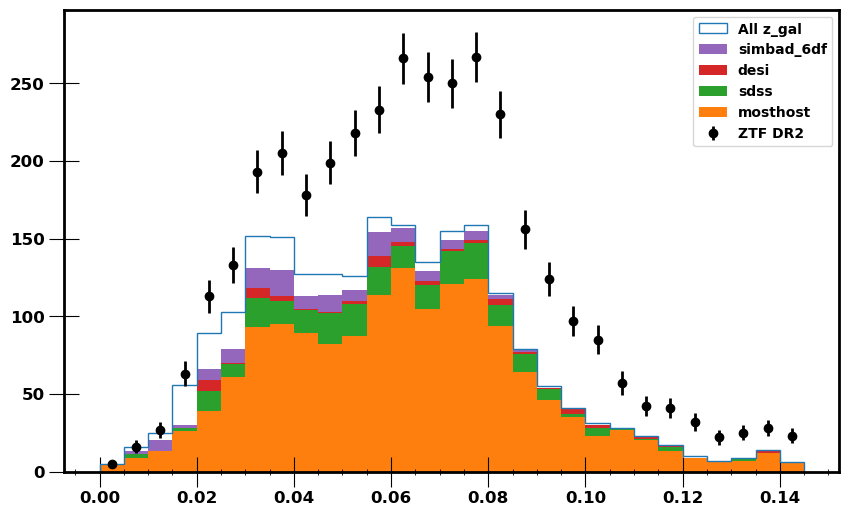

In [13]:
plt.figure(figsize=(10, 6))
host_count,_,_=plt.hist(host_z.z,
         bins=ztf_bins,
         histtype='step',
         label="All z_gal")

plt.errorbar(ztf_cent_bins, ztf_count_all, yerr=np.sqrt(ztf_count_all), marker='o', color='k', elinewidth=2, linestyle='', label='ZTF DR2')
sources = ["mosthost", "sdss", "desi",
           "simbad_6df"]
plt.hist([host_z[host_z.z_source == source].z for source in sources],
         bins=ztf_bins,
         stacked=True,
         histtype='stepfilled',
         label=sources)
plt.legend()
# plt.yscale('log')


### Selection function

In [129]:
def sigmoid(x, mlim, slim):
    return 1/(1+np.exp(-(mlim - x)/slim))

In [130]:
mlim, slim = 18.59, 0.25

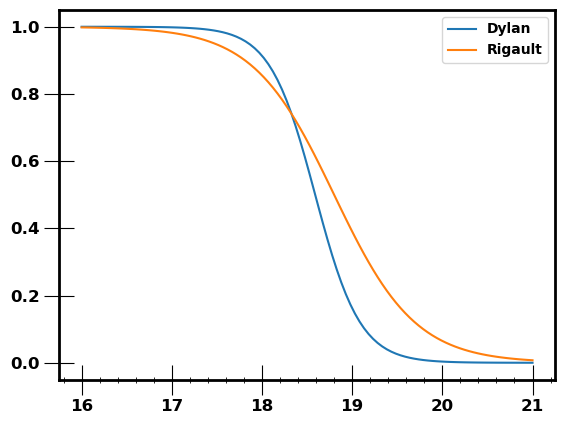

In [131]:
%matplotlib inline
xx = np.linspace(16, 21, 100)
plt.plot(xx, sigmoid(xx, mlim, slim), label='Dylan')
plt.plot(xx, sigmoid(xx, 18.8, 0.45), label='Rigault')
plt.legend()

In [ ]:
halos = pandas.read_csv("./data/reduced_hbt/halos_highres_0.csv", index_col=0)

Text(0.5, 0, '$z$')

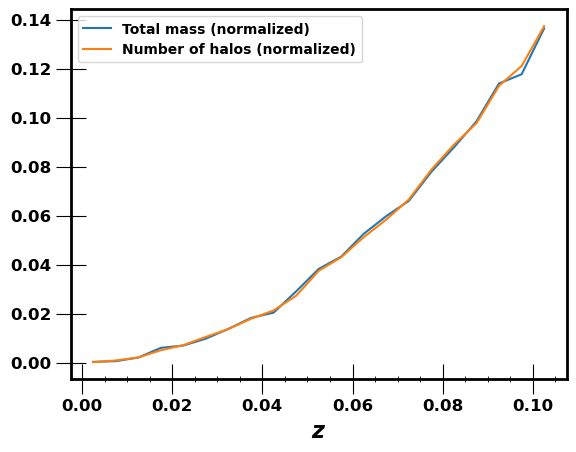

In [ ]:
idx = halos.z.argsort()
to_bin = halos.z[idx]
data = halos.BoundM200Crit[idx]
halos_bins=np.arange(0, 0.11, 0.005)
bounds=np.concatenate((
    to_bin.searchsorted(halos_bins[:-1], 'left'),
    to_bin.searchsorted(halos_bins[-1:], 'right')))
mass = np.array([data[start:stop].sum() for start, stop in zip(bounds[:-1],bounds[1:])])
number = np.array([data[start:stop].count() for start, stop in zip(bounds[:-1],bounds[1:])])

halos_cen_bins=(halos_bins[:-1]+halos_bins[1:])/2

plt.plot(halos_cen_bins, mass/mass.sum(), label='Total mass (normalized)')
plt.plot(halos_cen_bins, number/number.sum(), label='Number of halos (normalized)')
plt.legend()
plt.xlabel(r"$z$")

# Nice plots

### utilities

In [ ]:
import ztfcosmo
ztf = ztfcosmo.get_data()
scl = pandas.read_pickle('./data/SCl/SCl.pkl')
scl.loc[scl.f_SCl.isna(), 'f_SCl'] = ''
scl.loc[scl.CName.isna(), 'CName'] = ''
Abell_tot = pandas.read_csv('./data/Abell/tot.csv', index_col=0, dtype={'index':str})
normalize=pandas.read_csv('./data/reduced_hbt/mass_radius_norm.csv', index_col=0)
NED = pandas.read_csv('./data/Abell/NED_table.csv', index_col=0, dtype={'index':str})

In [ ]:
ztf_bins = np.arange(0, 0.15, 0.005)
ztf_cent_bins = (ztf_bins[:-1] + ztf_bins[1:])/2
ztf_count_all,_ = np.histogram(ztf.redshift, ztf_bins)
ztf_goods = ztf[(ztf.lccoverage_flag==1.0) & (ztf.fitquality_flag == 1.0)]
ztf_count,_ = np.histogram(ztf_goods.redshift, ztf_bins)

def plot_ztf(ztf_cent_bins, ztf_count, norm=1, ax=None, **kwargs):
    if ax is None:
        ax=plt.gca()
    default_kwargs=dict(marker='o', color='k', elinewidth=2, linestyle='', label='ZTF DR2')
    default_kwargs.update(**kwargs)
    ax.errorbar(ztf_cent_bins, ztf_count*norm, yerr=np.sqrt(ztf_count)*norm, **default_kwargs)

In [ ]:
import ztfcosmo
ztf = ztfcosmo.get_data()
scl = pandas.read_pickle('./data/SCl/SCl.pkl')
scl.loc[scl.f_SCl.isna(), 'f_SCl'] = ''
scl.loc[scl.CName.isna(), 'CName'] = ''
Abell_tot = pandas.read_csv('./data/Abell/tot.csv', index_col=0, dtype={'index':str})
normalize=pandas.read_csv('./data/reduced_hbt/mass_radius_norm.csv', index_col=0)
NED = pandas.read_csv('./data/Abell/NED_table.csv', index_col=0, dtype={'index':str})

In [ ]:
def halo_den_profile(r, rho, R, alpha=0.16):
    return rho*np.exp(-2/alpha*(np.power(r/R, alpha) - 1))
def _integ(r, rho, R):
    return 4*np.pi*np.square(r)*halo_den_profile(r, rho, R)

In [ ]:
from astropy.coordinates import SkyCoord
from astropy.units import degree, Mpc

def halo_img(halos, ra_range, dec_range, z_range, z_img=None, n_ra=200, n_dec=200, use_dist=True, ):
    halos_filt = halos.z.between(*z_range) & halos.ra.between(*ra_range) & halos.dec.between(*dec_range)
    ra, dec = np.linspace(*ra_range, n_ra), np.linspace(*dec_range, n_dec)
    RA, DEC = np.meshgrid(ra, dec)
    h_img = np.zeros_like(RA)
    if z_img is None:
        z_img = np.mean(z_range)
    if use_dist:
        halos_filt &= (np.abs((cosmo.comoving_distance(halos.z) - cosmo.comoving_distance(z_img)).value) < halos.Rmax.values)
    
    halos_coord = SkyCoord(halos.loc[halos_filt, 'ra'].values*degree,
                       halos.loc[halos_filt, 'dec'].values*degree,
                       distance=halos.loc[halos_filt, 'd_c'].values*Mpc)

    img_coords = SkyCoord(RA*degree , DEC*degree, distance=cosmo.comoving_distance(z_img)*np.ones((n_dec, n_dec)))

    if use_dist:
        for h_c, R, rho in tqdm(zip(halos_coord,
                                    halos.loc[halos_filt, 'BoundR200CritComoving'],
                                    halos.loc[halos_filt, 'rho']),
                                total=halos_filt.sum(), leave=False, desc='Building image'):
            h_img += halo_den_profile(img_coords.separation_3d(h_c).value, rho, R)
    else:
        for h_c, R, rho in tqdm(zip(halos_coord,
                                    halos.loc[halos_filt, 'BoundR200CritComoving'],
                                    halos.loc[halos_filt, 'rho']),
                                total=halos_filt.sum(), leave=False, desc='Building image'):
            h_img += halo_den_profile(img_coords.separation(h_c).to("rad").value*cosmo.angular_diameter_distance(z_img).value, rho, R)

    return ra, dec, h_img

In [ ]:
snia = skysurvey.SNeIa()
N = 200
n_sn = 30000
counts = []
for n in tqdm(range(N)):
    data = snia.draw(n_sn, zmax=0.15)
    sel_ = np.random.choice(data[np.random.random(size=n_sn) < sigmoid(data.magobs, 18.59, 0.25)].index, size=len(ztf_goods))
    counts.append(np.histogram(data.loc[sel_, 'z'], bins=ztf_bins)[0])
counts=np.vstack(counts)

In [ ]:
for scl_name, aco_list in scl.loc[(scl.CName != "") & (scl.DEdeg > -27), ['CName', 'AC_list']].values:
    # print(scl_name.replace(' ', '_').replace('-', '_'), '=', aco_list)

Pegasus_Pisces = ['0003', '0016', '0017', '2694', '2698', '2700', '2706', '2691', '2696']
Aquarius_A = ['0013', '2682', '2710', '2719', '2756']
Pisces_Cetus = ['0014', '0027', '0074', '0080', '0085', '0086', '0093', '0114', '0117', '0133', '0151', '2660', '2686', '2716', '2734', '2800', '2816', '2824', '4053']
Pisces = ['0076', '0119', '0147', '0160', '0168', '0193', '0195']
Pisces_Aries = ['0150', '0154', '0158', '0171', '0225', '0257', '0292', '0311']
Perseus = ['0262', '0347', '0426']
Sextans = ['0970', '0978', '0979', '0993', '1069']
Draco_Ursa_Majoris = ['0718', '0786', '0809', '0818', '0848', '0948', '1029', '1123', '1150', '1297', '1301', '1381', '1484', '1536']
Leo_Sextans = ['1024', '1032', '1066', '1078', '1080', '1149', '1171', '1205', '1238']
Leo = ['0999', '1016', '1139', '1142', '1177', '1185', '1228', '1257', '1267', '1314']
Leo_A = ['1189', '1200', '1214', '1296', '1364', '1386', '1389', '1399', '1404']
Leo_Virgo = ['1341', '1342', '1345', '1354', '1356', '1372', '1379'

In [ ]:
Pegasus_Pisces = ['0003', '0016', '0017', '2694', '2698', '2700', '2706', '2691', '2696']
Aquarius_A = ['0013', '2682', '2710', '2719', '2756']
Pisces_Cetus = ['0014', '0027', '0074', '0085', '0086', '0093', '0114', '0117', '0133', '0151', '2660', '2716', '2734', '2800', '2824', '4053']
Pisces_Cetus_b = ['0080', '2686', '2816']
Pisces = ['0076', '0119', '0147', '0160', '0168', '0193', '0195']
Pisces_Aries = ['0150', '0154', '0158', '0171', '0225', '0257', '0292', '0311']
Perseus = ['0262', '0347', '0426']
Sextans = ['0970', '0978', '0979', '0993', '1069']
Draco_Ursa_Majoris = ['0718', '0786', '0809', '0818', '0848', '0948', '1029', '1123', '1150', '1297', '1301', '1381', '1484', '1536']
Leo_Sextans = ['1024', '1032', '1066', '1149', '1171', '1205', '1238']
Leo_Sextans_b = ['1078', '1080']
Leo = ['0999', '1016', '1139', '1142', '1177', '1185', '1228', '1257', '1267', '1314']
Leo_A = ['1189', '1200', '1296', '1364', '1386', '1389', '1399', '1404']
Leo_Virgo = ['1341', '1342', '1345', '1354', '1356', '1372', '1379', '1435']
Ursa_Majoris = ['1270', '1291', '1318', '1377', '1383', '1436', '1452', '1507']
Virgo_Coma = ['1307', '1337', '1358', '1385', '1390', '1424', '1459', '1474', '1516', '1526', '1527', '1541', '1552', '1564']
Draco = ['1289', '1302', '1322', '1366', '1402', '1406', '1421', '1432', '1446', '1477', '1518', '1559', '1566', '1621', '1646']
Coma = ['1367', '1656']
Bootes = ['1775', '1781', '1795', '1800', '1825', '1827', '1828', '1831', '1873', '1898', '1927']
Bootes_A = ['1960', '1972', '1976', '1980', '1986', '1988', '1997', '2001', '2006', '2017', '2036']
Corona_Borealis = ['2019', '2061', '2065', '2067', '2079', '2089', '2092', '2124']
Hercules = ['2040', '2052', '2063', '2107', '2147', '2151', '2152', '2162', '2197', '2199']
Aquarius_Cetus = ['2361', '2362', '2366', '2372', '2382', '2399', '2401', '2415']
Aquarius_Capricornus = ['2370', '2378', '2394', '2412']
Aquarius_B = ['2376', '2377', '2400', '2402', '2410', '2420', '2428', '2448']
Aquarius = ['2456', '2459', '2462', '2480', '2492', '2500', '2502', '2523', '2528', '2538', '2539', '2541', '2556', '2566', '2586', '2596', '2599', '2600', '2605']

In [ ]:
scl_windows = {'Pegasus_Pisces' : dict(z_range = (0.083, 0.10), ra_range = (-5, 10), dec_range = (-10, 15)),
               'Aquarius_A' : dict(z_range = (0.097, 0.12), ra_range = (-5, 10), dec_range = (-25, -15)),
               'Pisces_Cetus' : dict(z_range = (0.05, 0.071), ra_range = (-5, 20), dec_range = (-30, -5)),
               'Pisces' : dict(z_range = (0.038, 0.05), ra_range = (5, 25), dec_range = (-5, 20)),
               'Pisces_Aries' : dict(z_range = (0.052, 0.071), ra_range = (15, 35), dec_range = (10, 25)),
               'Perseus' : dict(z_range = (0.015, 0.019), ra_range = (20, 55), dec_range = (30, 45)),
               'Sextans' : dict(z_range = (0.053, 0.066), ra_range = (150, 165), dec_range = (-15, 0)),
               'Leo_Sextans' : dict(z_range = (0.065, 0.076), ra_range = (150, 175), dec_range = (-5, 15)),
               'Leo' : dict(z_range = (0.031, 0.04), ra_range = (145, 185), dec_range = (-5, 50)),
               'Leo_A' : dict(z_range = (0.077, 0.106), ra_range = (165, 185), dec_range = (-10, 5)),
               'Leo_Virgo' : dict(z_range = (0.060, 0.118), ra_range = (170, 180), dec_range = (5, 15)),
               'Ursa_Majoris' : dict(z_range = (0.05, 0.07), ra_range = (165, 190), dec_range = (50, 65)),
               'Virgo_Coma' : dict(z_range = (0.074, 0.093), ra_range = (170, 190), dec_range = (0, 20)),
               'Coma' : dict(z_range = (0.021, 0.025), ra_range = (170, 200), dec_range = (15, 30)),
               'Bootes' : dict(z_range = (0.061, 0.095), ra_range = (200, 220), dec_range = (15, 35)),
               'Bootes_A' : dict(z_range = (0.11, 0.13), ra_range = (220, 230), dec_range = (15, 25)), # Very high redshift but somehow 2 ZTF SNe
               'Corona_Borealis' : dict(z_range = (0.065, 0.081), ra_range = (220, 240), dec_range = (25, 40)),
               'Hercules' : dict(z_range = (0.030, 0.046), ra_range = (210, 255), dec_range = (5, 45)),
               'Aquarius_Cetus' : dict(z_range = (0.052, 0.064), ra_range = (320, 335), dec_range = (-25, -5)),
               'Aquarius_Capricornus' : dict(z_range = (0.058, 0.083), ra_range = (320, 335), dec_range = (-30, -15)),
               'Aquarius_B' : dict(z_range = (0.08, 0.12), ra_range = (320, 340), dec_range = (-15, -5)),
               'Aquarius' : dict(z_range = (0.069, 0.12), ra_range = (335, 355), dec_range = (-30, -10)),
               }

## Paper Plots

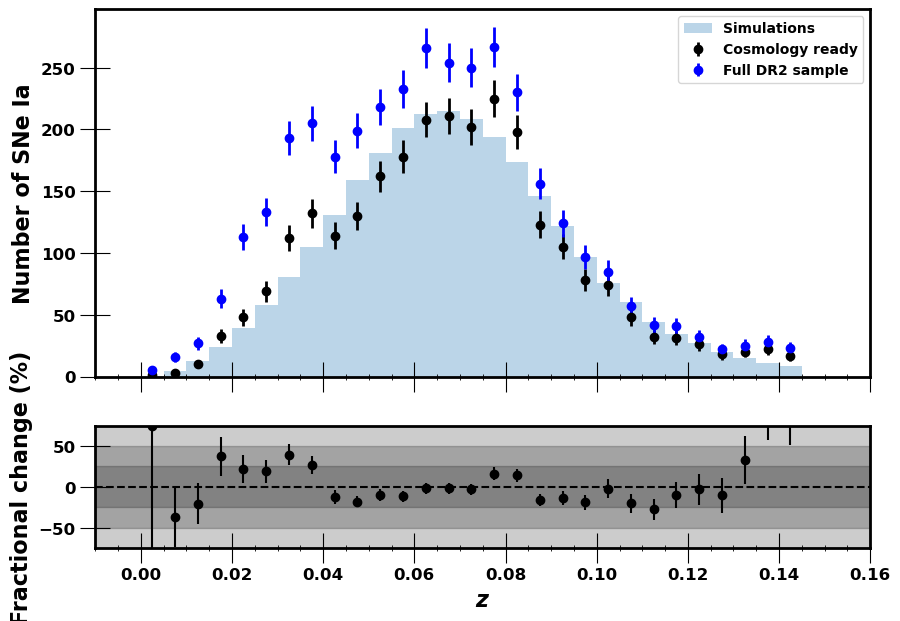

In [217]:
fig, (axhist, axpull) = plt.subplots(nrows=2, figsize=(10, 7), sharex='col', gridspec_kw={"height_ratios": [3, 1]})

axhist.stairs(np.mean(counts, axis=0), ztf_bins, fill=True, alpha=0.3, label='Simulations')
plot_ztf(ztf_cent_bins, ztf_count, ax=axhist, label='Cosmology ready')
plot_ztf(ztf_cent_bins, ztf_count_all, ax=axhist, label='Full DR2 sample', color='b')

axhist.legend()
axhist.set_ylabel('Number of SNe Ia')

# ̈Pulls
# axpull.plot(ztf_cent_bins, (ztf_count - np.mean(counts, axis=0))/np.sqrt(ztf_count), marker='o', color='k', linestyle='')
# for k in range(4):
#     axpull.fill_between([-0.01, 0.16], -k, k, color='k', alpha=0.2)
# axpull.set_ylabel(r'Pulls')
# axpull.set_ylim(-4, 4)

#  Fractionnal change
axpull.errorbar(ztf_cent_bins, (ztf_count/np.mean(counts, axis=0) - 1)*100, np.sqrt(ztf_count)/np.mean(counts, axis=0)*100, marker='o', color='k', linestyle='')
for k in [25, 50, 75]:
    axpull.fill_between([-0.01, 0.16], -k, +k, color='k', alpha=0.2)
axpull.set_ylabel(r'Fractional change (%)')
axpull.set_ylim(-75, 75)

axpull.set_xlim(-0.01, 0.16)
axpull.axhline(0, color='k', linestyle='--')
axpull.set_xlabel(r'$z$')

plt.savefig('../../ZTF_DR2/z_dist_fractional_change.svg')

In [13]:
hercules_halos = pandas.read_csv('./data/reduced_hbt/Hercules.csv')

In [96]:
hercules_halos['rho'] = normalize.loc[hercules_halos.BoundM200Crit, "rho"].values
hercules_halos['Rmax'] = normalize.loc[hercules_halos.BoundM200Crit, "Rmax"].values

In [117]:
ra_, dec_, mean_img = halo_img(hercules_halos, z_range = (0.030, 0.040), ra_range = (210, 255), dec_range = (5, 45),
                               z_img=0.035, n_ra=200, n_dec=200,
                               )
mean_img/= 50

ra_, dec_, mean_img_ = halo_img(hercules_halos, z_range = (0.030, 0.040), ra_range = (210, 255), dec_range = (5, 45),
                               z_img=0.035, n_ra=200, n_dec=200,
                               use_dist=False,
                               )
mean_img_/= 50

Building image:   0%|          | 0/33644 [00:00<?, ?it/s]

Building image:   0%|          | 0/72094 [00:00<?, ?it/s]

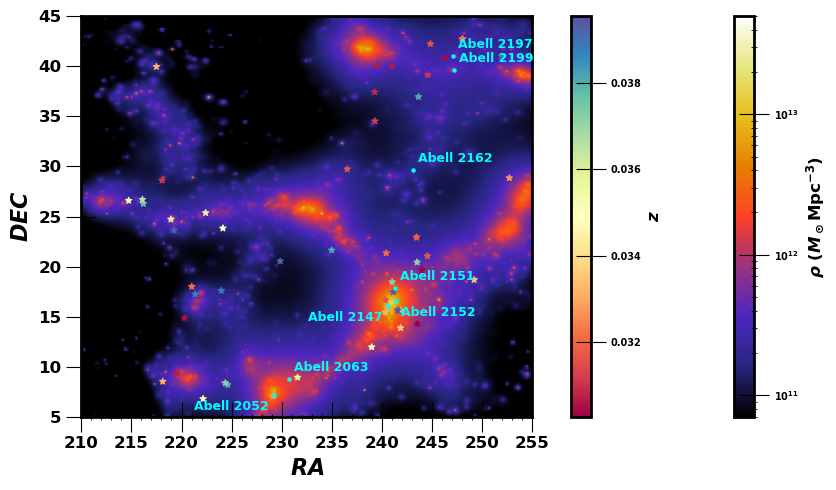

In [116]:
fig, ax = plt.subplots(figsize=(10, 5))
scl_name = 'Hercules'
z_range = (0.030, 0.040)

im = ax.imshow(mean_img*1e10, norm='log', vmin=7e10, vmax=5e13,
           extent=[*scl_windows[scl_name]['ra_range'], *scl_windows[scl_name]['dec_range']], origin='lower',
           cmap='CMRmap')
cb_dm = plt.colorbar(im, ax=ax)
cb_dm.ax.tick_params(labelsize=7) 
cb_dm.set_label(label=r'$\rho$ ($M_\odot$Mpc$^{-3}$)', fontsize=12)


ztf_filt = ztf.redshift.between(*z_range) & ztf.ra.between(*scl_windows[scl_name]['ra_range']) & ztf.dec.between(*scl_windows[scl_name]['dec_range'])
p = ax.scatter(ztf[ztf_filt].ra, ztf[ztf_filt].dec,
           marker='*',
        #    color='gold',
           c=ztf[ztf_filt].redshift,
           cmap='Spectral',
           s=20, alpha=1, label="ZTF DR2")
cb_ztf = plt.colorbar(p, ax=ax,)
cb_ztf.ax.tick_params(labelsize=7) 
cb_ztf.set_label(r'$z$', fontsize=12)

# ax.scatter(ztf[~ztf_filt].ra, ztf[~ztf_filt].dec, marker='.', color='b', s=10, alpha=1, label="others")

abell_filt = Abell_tot.z.between(*z_range) & Abell_tot.ra.between(*scl_windows[scl_name]['ra_range']) & Abell_tot.dec.between(*scl_windows[scl_name]['dec_range'])
ax.scatter(Abell_tot[abell_filt].ra,
           Abell_tot[abell_filt].dec,
           marker='.', color='aqua', s=20, alpha=1)
label_loc={'Abell 2147':dict(ha='right', va='top'),
           'Abell 2152':dict(ha='left', va='top'),
           'Abell 2052':dict(ha='right', va='top')
           }
for name, ra, dec in Abell_tot[abell_filt][["name", "ra", "dec"]].values:
    def_pos = dict(ha='left', va='bottom')
    sign_ra, sign_dec = 1., 1.
    if name in label_loc:
        if 'ha' in label_loc[name].keys():
            sign_ra = 1.*(label_loc[name]['ha']=='left') - 1.*(label_loc[name]['ha']=='right')
        if 'va' in label_loc[name].keys():
            sign_dec = 1.*(label_loc[name]['va']=='bottom') - 1.*(label_loc[name]['va']=='top')
        def_pos.update(label_loc[name])
    ax.text(ra + sign_ra * 0.5, dec + sign_dec*0.5, name, fontsize=9, color='aqua', **def_pos)

ax.set_xlabel('$RA$')
ax.set_ylabel('$DEC$')
fig.tight_layout(h_pad=1.1)






In [62]:
scl_name='Hercules'
n_ra, n_dec = 200, 200
z_img=0.035
z_range= 0.03, 0.04
halos_filt = hercules_halos.z.between(*z_range) & \
             hercules_halos.ra.between(*scl_windows[scl_name]['ra_range']) & \
             hercules_halos.dec.between(*scl_windows[scl_name]['dec_range']) & \
             (np.abs((cosmo.comoving_distance(hercules_halos.z) - cosmo.comoving_distance(z_img)).value) < hercules_halos.Rmax.values)
halos_ = hercules_halos[halos_filt].copy()

In [66]:
img_coords = SkyCoord(RA*degree , DEC*degree, distance=cosmo.comoving_distance(z_img)*np.ones((n_dec, n_dec)))

In [78]:
hercules_halos.loc[halos_filt, 'ra'].values

array([242.22746308, 216.25578947, 245.1328861 , ..., 247.02764801,
       239.92651739, 245.98947052])

In [83]:
halos_coord = SkyCoord(hercules_halos.loc[halos_filt, 'ra'].values*degree,
                       hercules_halos.loc[halos_filt, 'dec'].values*degree,
                       distance=hercules_halos.loc[halos_filt, 'd_c'].values*Mpc)

In [86]:
img=np.zeros_like(RA)
for h_c, R, rho in tqdm(zip(halos_coord,
                    hercules_halos.loc[halos_filt, 'BoundR200CritComoving'],
                    hercules_halos.loc[halos_filt, 'rho']),
                total=halos_filt.sum()):
    img += halo_den_profile(img_coords.separation_3d(h_c).value, rho, R)

  0%|          | 0/33644 [00:00<?, ?it/s]

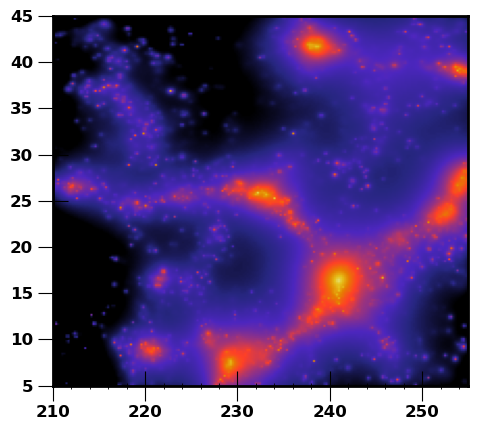

In [87]:
plt.imshow(img/50*1e10, norm='log', vmin=5e10, vmax=5e13,
           extent=[*scl_windows[scl_name]['ra_range'], *scl_windows[scl_name]['dec_range']], origin='lower',
           cmap='CMRmap')

In [22]:
from dustmaps.planck import PlanckQuery
from astropy.coordinates import SkyCoord
nside=128
ra, dec = healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), lonlat=True)
dusts = PlanckQuery()(SkyCoord(ra, dec, unit="deg"))
smoothed_dusts = healpy.smoothing(dusts, 0.1)

2025-06-03 15:46:38 INFO healpy - Sigma is 145.987664 arcmin (0.042466 rad) 
2025-06-03 15:46:38 INFO healpy - -> fwhm is 343.774677 arcmin
2025-06-03 15:46:38 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-06-03 15:46:38 INFO healpy - -> fwhm is 0.000000 arcmin


In [110]:
nside=128
map_dm = np.zeros(healpy.nside2npix(nside=nside))
map_vpec = np.zeros(healpy.nside2npix(nside=nside))
count = np.zeros(healpy.nside2npix(nside=nside))

count_vpec = []
vpecs = []
vpec_bins=np.linspace(0, 0.1, 30)

for nb in tqdm(range(50)):
    halos=pandas.read_csv(f'./data/reduced_hbt/halos_highres_{nb}.csv')
    filt_dm = halos.z.between(0.03, 0.04)
    index_dm = healpy.ang2pix(nside, halos[filt_dm].ra, halos[filt_dm].dec, lonlat=True)
    for id in index_dm.values:
        map_dm[id] += halos.loc[id, 'BoundM200Crit']
        map_vpec[id] += halos.loc[id, 'vpec']
        count[id] += 1
    
    idx = halos.z.values.argsort()
    to_bin = halos.z.values[idx]
    data = halos.vpec.values[idx]
    bounds =np.concatenate((
        to_bin.searchsorted(vpec_bins[:-1], 'left'),
        to_bin.searchsorted(vpec_bins[-1:], 'right')))
    count_vpec.append(np.diff(bounds))
    vpecs.append(np.array([data[bounds[k]:bounds[k+1]].sum() for k in range(len(bounds)-1)]))
map_vpec[count != 0] /= count[count!=0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
nside_dm = 128
map_dm = np.zeros(healpy.nside2npix(nside_dm))

for i in tqdm(range(50)):
    halos = pandas.read_csv(f'./data/reduced_hbt/halos_highres_{i}.csv', index_col=0)
    h_id = healpy.ang2pix(nside_dm, halos[halos.z < z_max].ra, halos[halos.z < z_max].dec, lonlat=True)
    pix_mass = pandas.DataFrame({'pix_id':h_id, 'h_mass':halos[halos.z < z_max].BoundM200Crit.values}).groupby('pix_id').sum()
    for pix_id in pix_mass.index:
        map_dm[pix_id] += pix_mass.loc[pix_id].values[0]
map_dm/=50

  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-31 18:52:32 INFO healpy - Sigma is 102.191365 arcmin (0.029726 rad) 
2025-05-31 18:52:32 INFO healpy - -> fwhm is 240.642274 arcmin
2025-05-31 18:52:32 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-31 18:52:32 INFO healpy - -> fwhm is 0.000000 arcmin


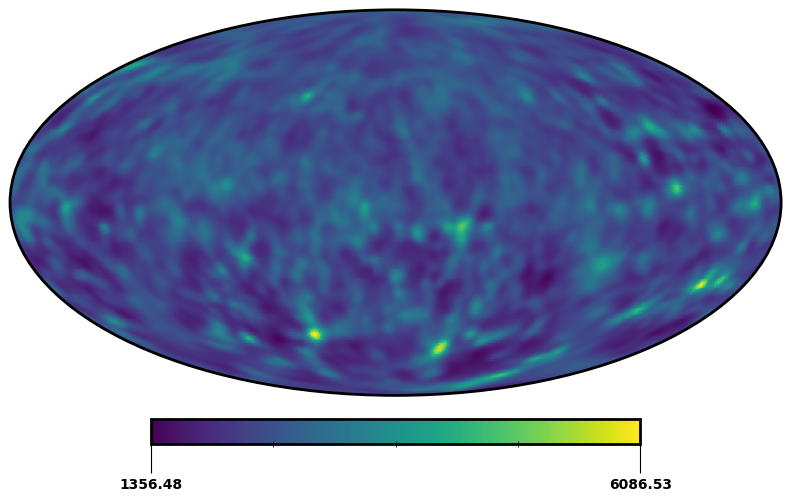

In [ ]:
healpy.projview(healpy.smoothing(map_dm, 0.07))

In [111]:
map_dm/=50
vpecs = np.vstack(vpecs)
count_vpec = np.vstack(count_vpec)

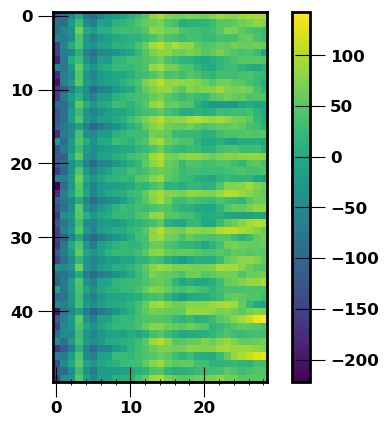

In [112]:
plt.imshow(vpecs/count_vpec)
plt.colorbar()

Text(0.5, 0, '$z$')

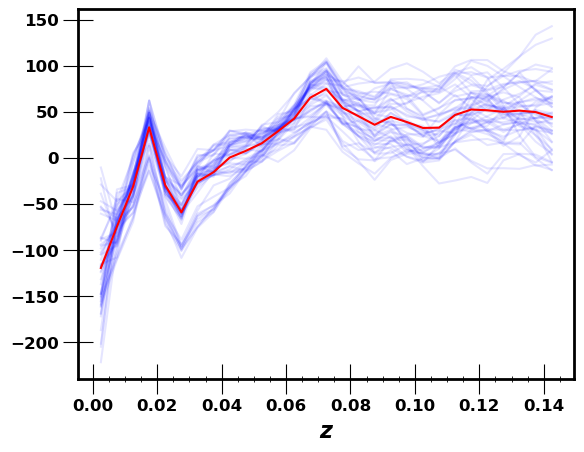

In [116]:
plt.plot(ztf_cent_bins, (vpecs/count_vpec).T, alpha=0.1, color='b', label='Mocks')
plt.plot(ztf_cent_bins, (vpecs/count_vpec).mean(axis=0), color='r', label='Mean')
plt.xlabel(r"$z$")

In [36]:
map_dm_ = np.copy(map_dm)
map_dm_[healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), lonlat=True)[1] < -30] = 0.
map_dm_[smoothed_dusts > 0.3] = 0.
smoothed_dm = healpy.smoothing(map_dm_, 0.2)

map_vpec_ = np.copy(map_vpec)
map_vpec_[healpy.pix2ang(nside, np.arange(healpy.nside2npix(nside)), lonlat=True)[1] < -30] = 0.
map_vpec_[smoothed_dusts > 0.3] = 0.
smoothed_vpec = healpy.smoothing(map_vpec_, 0.2)


2025-05-15 11:06:48 INFO healpy - Sigma is 291.975328 arcmin (0.084932 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 687.549354 arcmin
2025-05-15 11:06:48 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 0.000000 arcmin
2025-05-15 11:06:48 INFO healpy - Sigma is 291.975328 arcmin (0.084932 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 687.549354 arcmin
2025-05-15 11:06:48 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:48 INFO healpy - -> fwhm is 0.000000 arcmin


In [37]:
from astropy.units import degree, rad, Gpc
norm = 1/(cosmo.comoving_distance(0.04) - cosmo.comoving_distance(0.03))/(cosmo.angular_diameter_distance(0.035) * np.sqrt(healpy.nside2pixarea(nside, degrees=False)))**2

In [38]:
nside=128
map_ = np.zeros(healpy.nside2npix(nside=nside))
index = healpy.ang2pix(nside, ztf[ztf.redshift.between(0.03, 0.04)].ra, ztf[ztf.redshift.between(0.03, 0.04)].dec, lonlat=True)

for id in index.values:
    map_[id] += 1

low_smoothed_map = healpy.smoothing(map_, 0.07)
high_smoothed_map = healpy.smoothing(map_, 0.3)

2025-05-15 11:06:49 INFO healpy - Sigma is 102.191365 arcmin (0.029726 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 240.642274 arcmin
2025-05-15 11:06:49 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 0.000000 arcmin
2025-05-15 11:06:49 INFO healpy - Sigma is 437.962991 arcmin (0.127398 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 1031.324031 arcmin
2025-05-15 11:06:49 INFO healpy - Sigma is 0.000000 arcmin (0.000000 rad) 
2025-05-15 11:06:49 INFO healpy - -> fwhm is 0.000000 arcmin


In [119]:
def add_clusters(clusters, ax=None, color="tab:red"):
    if ax==None:
        ax=plt.gca()    
    scatter_mollweide(clusters, ax=ax, marker='*', color=color, s=50, alpha=1)
    for name, ra, dec in clusters[["name", "ra", "dec"]].values:
        ax.text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.03, dec*np.pi/180 +0.03, name, fontsize=7, color=color)

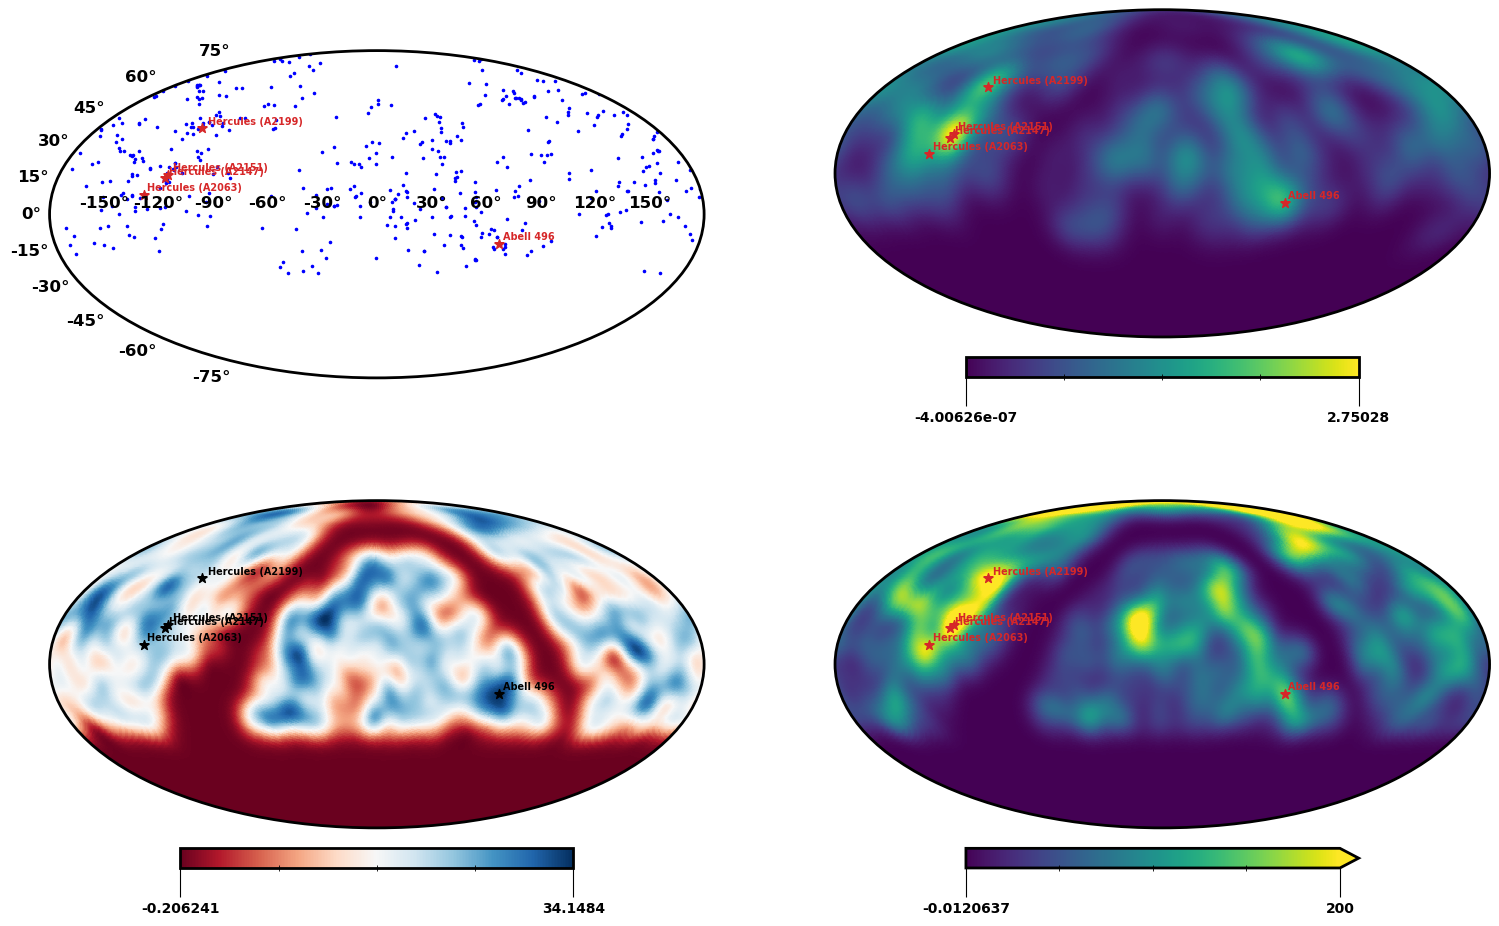

In [123]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=2, subplot_kw=dict(projection="mollweide"))
scatter_mollweide(ztf[ztf.redshift.between(0.03, 0.042)], ax=fig.axes[0], marker='.', color='blue', s=10, alpha=1, label="bump")
healpy.projview(high_smoothed_map*norm.value/3/2.35*10**5, projection_type="mollweide", fig=fig, sub=222, flip='geo')
healpy.projview(smoothed_vpec, projection_type="mollweide", fig=fig, sub=223, cmap='RdBu', flip='geo')
healpy.projview(smoothed_dm, projection_type="mollweide", max=200, fig=fig, sub=224, flip='geo')

for ax, c in zip(fig.axes[0:4], ['tab:red', 'tab:red', 'k', 'tab:red']):
    add_clusters(clusters[clusters.z.between(0.03, 0.04)], ax, color=c)
plt.savefig('../../Hercules_vpec_dm_SN_SNd.png')

In [124]:
densities=smoothed_dm[healpy.ang2pix(nside, clusters[clusters.z.between(0.03,0.04)].ra, clusters[clusters.z.between(0.03,0.04)].dec, lonlat=True,)]

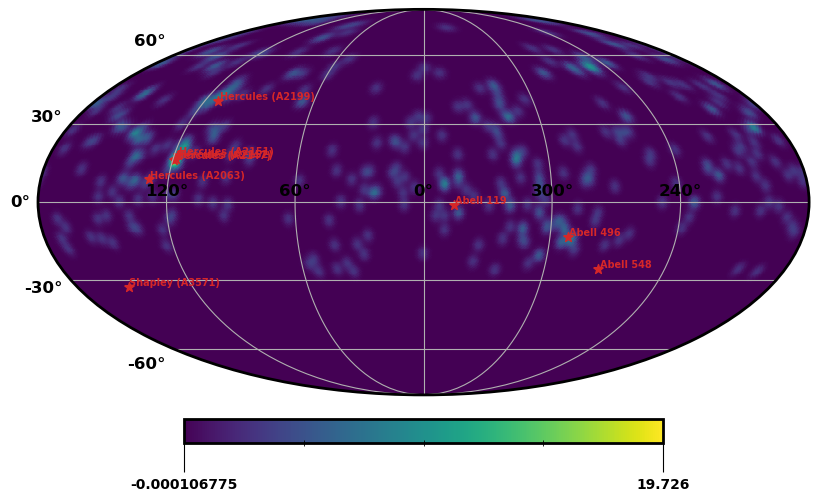

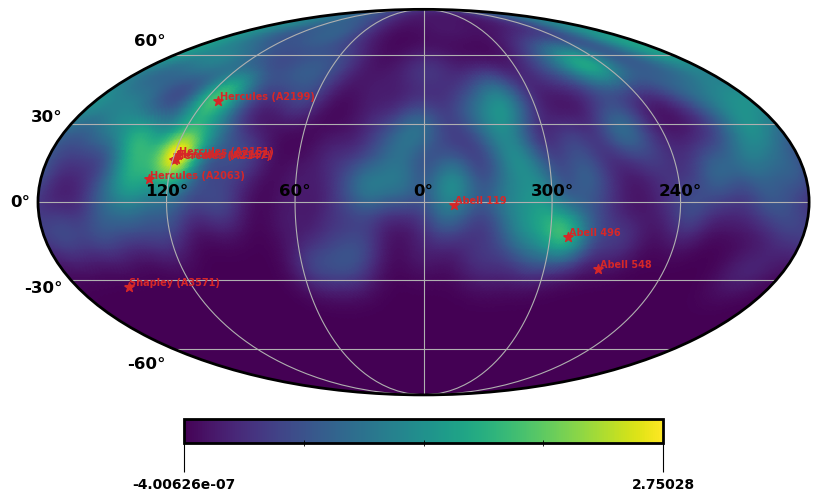

In [125]:
healpy.projview(low_smoothed_map*norm.value/3/2.35*10**5, graticule=True, graticule_labels =True, flip='geo')
scatter_mollweide(clusters[clusters.z.between(0.03, 0.045)], ax=plt.gca(), marker='*', color='tab:red', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.045)][["name", "ra", "dec"]].values:
    plt.gca().text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.01, dec*np.pi/180 +0.01, name, fontsize=7, color='tab:red')

healpy.projview(high_smoothed_map*norm.value/3/2.35*10**5, graticule=True, graticule_labels =True, flip='geo')
scatter_mollweide(clusters[clusters.z.between(0.03, 0.045)], ax=plt.gca(), marker='*', color='tab:red', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.045)][["name", "ra", "dec"]].values:
    plt.gca().text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.01, dec*np.pi/180 +0.01, name, fontsize=7, color='tab:red')


In [ ]:
healpy.nside2pixarea(nside, degrees=True)

0.2098234113027917

(array([  5.,  16.,  27.,  63., 113., 133., 173., 192., 178., 199., 218.,
        233., 266., 254., 250., 267., 230., 156., 124.,  97.,  85.,  57.,
         42.,  41.,  32.,  22.,  25.,  28.,  23.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
        0.135, 0.14 , 0.145]),
 <BarContainer object of 29 artists>)

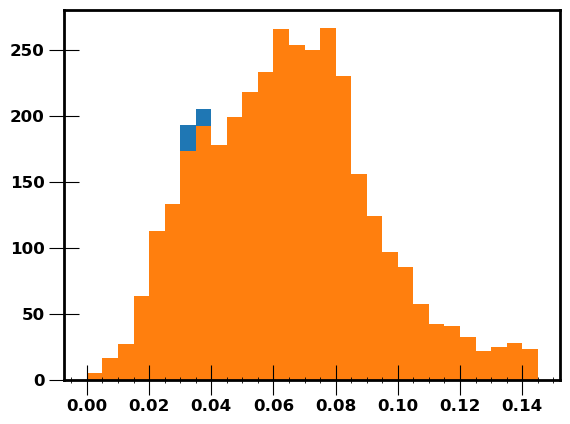

In [85]:
plt.hist(ztf.redshift, bins=ztf_bins, label='ZTF sample')
plt.hist(ztf[~ztf.index.isin(near_clusters)].redshift, bins=ztf_bins, label='ZTF without clusters')

Text(0, 0.5, '$N_{SN}$')

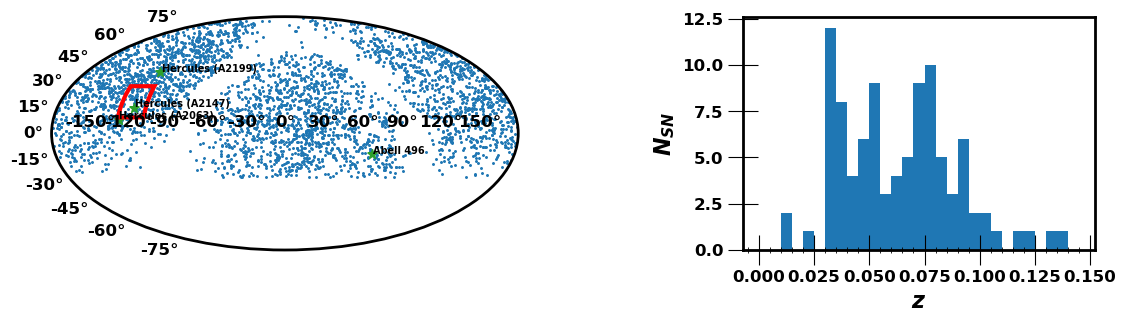

In [173]:
fig = plt.figure(figsize=(15, 10))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 2])

ax_moll = fig.add_subplot(gs[0], projection='mollweide')
ra_origin, dec_origin, ra_size, dec_size = (230, 10, 20, 20)

scatter_mollweide(ztf, ax=ax_moll, s=5, alpha=1)
scatter_mollweide(clusters[clusters.z.between(0.03, 0.04)], ax=ax_moll, marker='*', color='tab:green', s=50, alpha=1)
for name, ra, dec in clusters[clusters.z.between(0.03, 0.04)][["name", "ra", "dec"]].values:
    ax_moll.text(ra*np.pi/180 - 2*np.pi*(ra > 180) +0.01, dec*np.pi/180 +0.01, name, fontsize=7, color='k')
rect = plt.Rectangle((ra_origin*np.pi/180 - 2*np.pi*(ra_origin > 180), dec_origin*np.pi/180), ra_size*np.pi/180, dec_size*np.pi/180, edgecolor='r', fill=False, linewidth=3, alpha=1)
ax_moll.add_patch(rect)
ax_hist = fig.add_subplot(gs[1])

ax_hist.hist(ztf[ztf.ra.between(ra_origin, ra_origin+ra_size,) & ztf.dec.between(dec_origin, dec_origin+dec_size)].redshift, bins=ztf_bins)
ax_hist.set_xlabel(r"$z$")
ax_hist.set_ylabel(r"$N_{SN}$")

Text(0.5, 1.0, 'Others')

<Figure size 640x480 with 0 Axes>

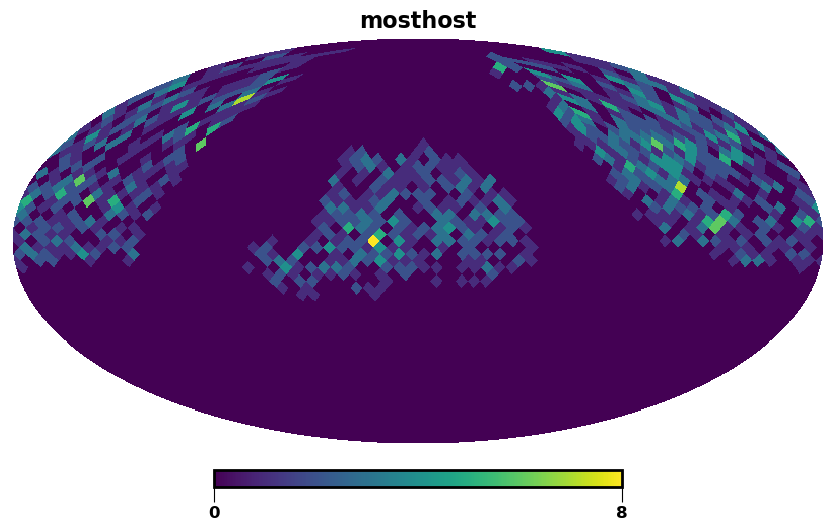

<Figure size 640x480 with 0 Axes>

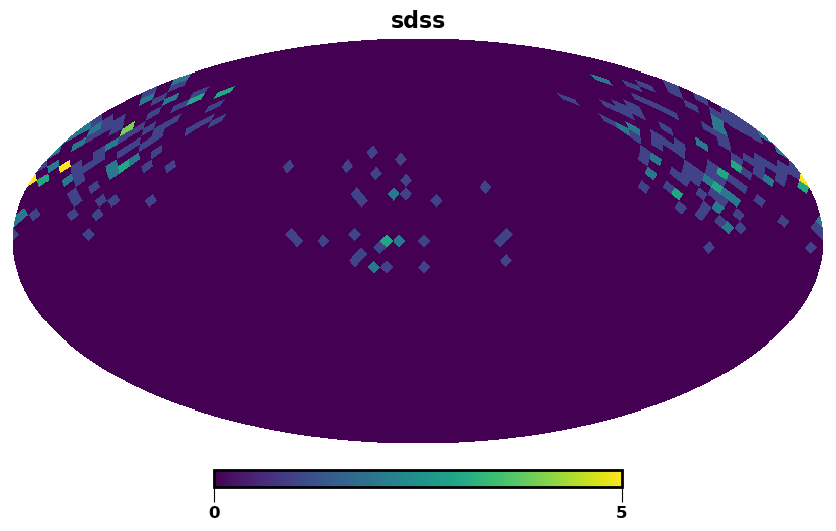

<Figure size 640x480 with 0 Axes>

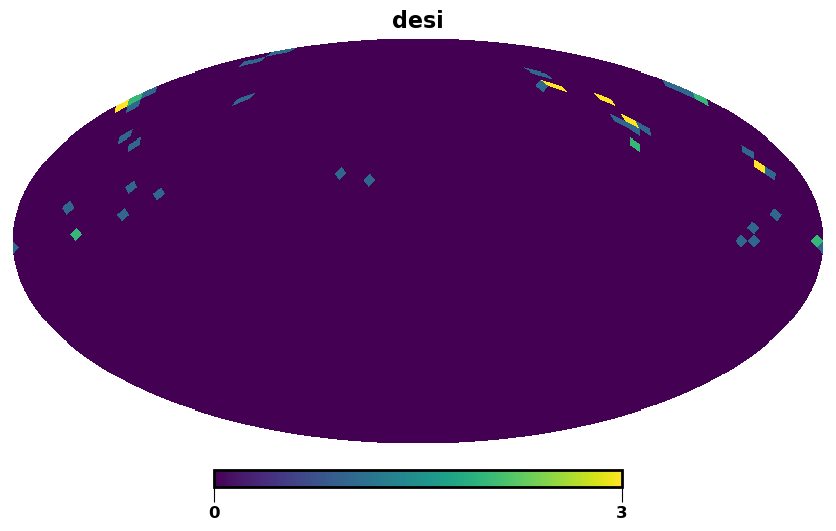

<Figure size 640x480 with 0 Axes>

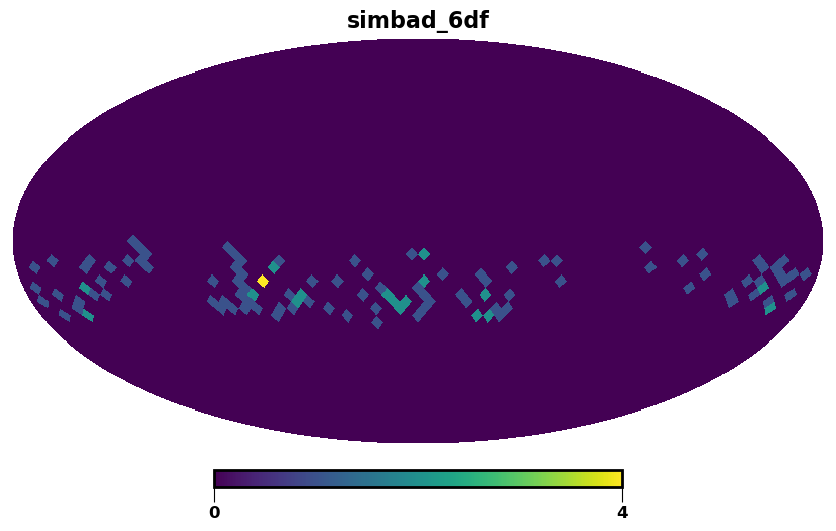

<Figure size 640x480 with 0 Axes>

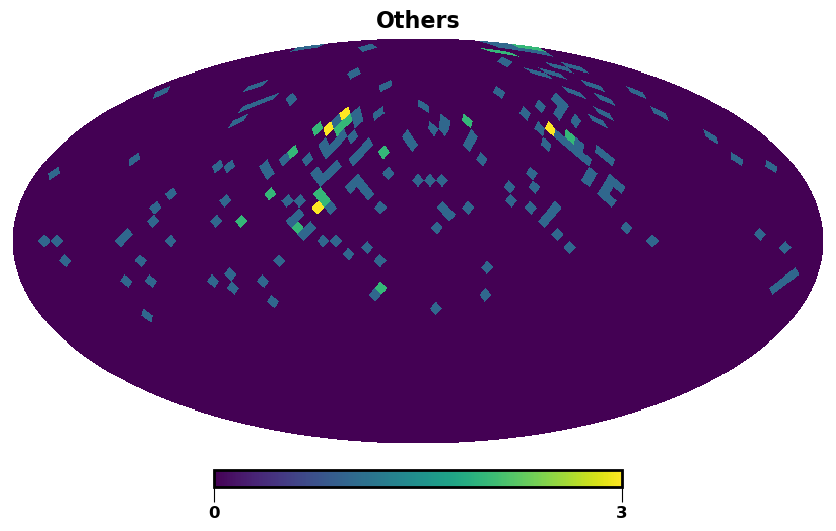

In [21]:
nside=16
for source in sources:
    plt.figure()
    sub_ztf = ztf[ztf.index.isin(host_z.ztfname[host_z.z_source==source])]
    healpy.mollview(np.bincount(healpy.ang2pix(nside, sub_ztf.ra, sub_ztf.dec, lonlat=True), minlength=healpy.nside2npix(nside)))    
    plt.title(source)

plt.figure()
sub_ztf = ztf[ztf.index.isin(host_z.ztfname[~host_z.z_source.isin(sources)])]
healpy.mollview(np.bincount(healpy.ang2pix(nside, sub_ztf.ra, sub_ztf.dec, lonlat=True), minlength=healpy.nside2npix(nside)))    
plt.title('Others')

In [22]:
SDSS_ = SDSS[np.abs(SDSS.redshift_err/SDSS.redshift) < 1e-1].copy()

In [23]:
halos=pandas.read_csv("data/2M++_subhalo_0.csv", index_col=0)

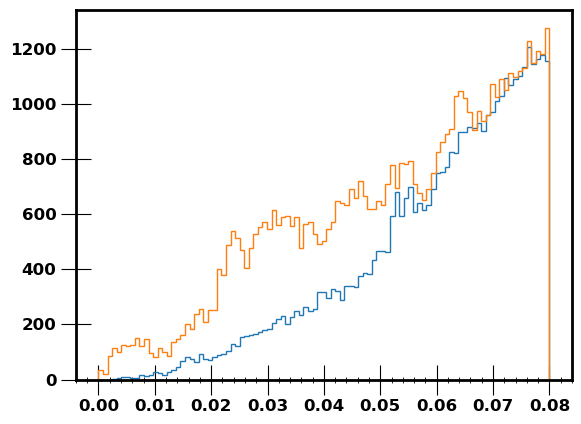

In [24]:
_=plt.hist(halos.z, bins=np.linspace(0, 0.08, 100), histtype='step')
_=plt.hist(SDSS_.redshift, bins=np.linspace(0, 0.08, 100), histtype='step')

In [25]:
vol_lim_ztf = ztf[ztf.redshift < 0.06]

In [26]:
def rand_positions(positions, size=1, weights=None, zcut=0.06):
    positions_ = positions[positions["z"] < zcut]
    if weights is not None:
        weights = weights[positions["z"] < zcut]
        weights /= weights.sum()
    index = np.random.choice(positions_.index, size=size, p=weights)

    return (
        positions_.loc[index].reset_index()["ra"],
        positions_.loc[index].reset_index()["dec"],
        positions_.loc[index].reset_index()["z"],
        np.array(index, dtype=int),
        positions_.loc[index].reset_index()["z_cosmo"],
    )



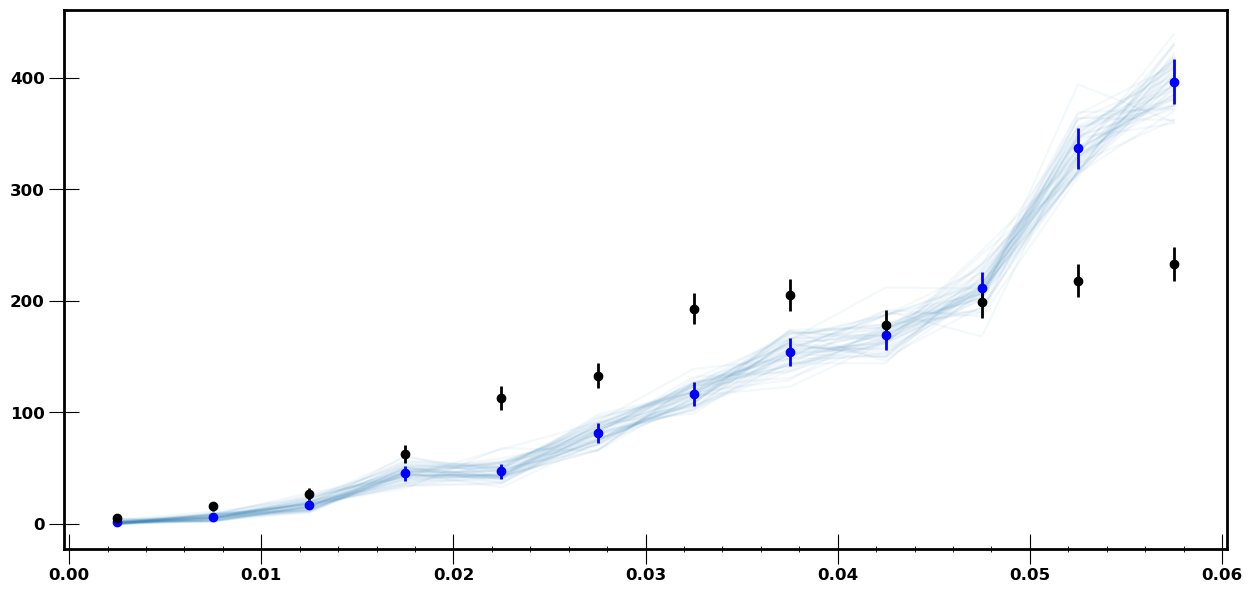

In [27]:
n_draw = 50

samples = [pandas.DataFrame(rand_positions(halos,
                                           size=len(vol_lim_ztf),
                                           weights=halos.M200c,
                                           zcut=0.06)).T
            for k in range(n_draw)]
vol_lim_bins = np.arange(0, 0.065, 0.005)
vol_lim_cen = (vol_lim_bins[1:] + vol_lim_bins[:-1])/2
counts = np.array([np.histogram(sample.z, bins=vol_lim_bins)[0] for sample in samples])
plt.figure(figsize=(15, 7))
plt.plot(vol_lim_cen, counts.T, alpha=0.05, color='tab:blue')
# plt.plot(vol_lim_cen, counts.mean(axis=0), color='tab:blue')
plot_ztf(vol_lim_cen, counts.mean(axis=0), color='b', label='simulations')

plot_ztf(ztf_cent_bins[:12], ztf_count_all[:12], label='ZTF DR2 goods')
